In [21]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch

CURRENT_DIR = os.getcwd()
INPUT_FILE = os.path.join(CURRENT_DIR, 'output','output_reviews_top.csv')
OUTPUT_FOLDER = os.path.join(CURRENT_DIR, 'output')

In [9]:
top_data_df = pd.read_csv(INPUT_FILE)
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')


In [10]:
print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]

Number of rows per star rating:
5    44392
4    25337
3    11362
1    10921
2     7988
Name: stars, dtype: int64


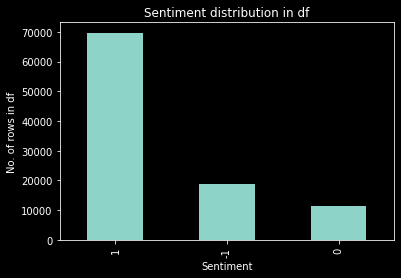

In [11]:
# # Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [12]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    10000
-1    10000
 0    10000
Name: sentiment, dtype: int64


,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
6,6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1
7,7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1
10,10,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5,2,0,0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,1
11,11,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45,1
12,12,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4,0,0,0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,1
13,13,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,1
14,14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05,1


In [13]:
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

1     [ve, taken, lot, of, spin, classes, over, the,...
3     [wow, yummy, different, delicious, our, favori...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [loved, this, tour, grabbed, groupon, and, the...
7     [amazingly, amazing, wings, and, homemade, ble...
10    [my, experience, with, shalimar, was, nothing,...
11    [locals, recommended, milktooth, and, it, an, ...
12    [love, going, here, for, happy, hour, or, dinn...
13    [good, food, loved, the, gnocchi, with, marina...
14    [the, bun, makes, the, sonoran, dog, it, like,...
Name: tokenized_text, dtype: object


In [14]:
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

1     [ve, taken, lot, of, spin, class, over, the, y...
3     [wow, yummi, differ, delici, our, favorit, is,...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [love, thi, tour, grab, groupon, and, the, pri...
7     [amazingli, amaz, wing, and, homemad, bleu, ch...
10    [my, experi, with, shalimar, wa, noth, but, wo...
11    [local, recommend, milktooth, and, it, an, ama...
12    [love, go, here, for, happi, hour, or, dinner,...
13    [good, food, love, the, gnocchi, with, marinar...
14    [the, bun, make, the, sonoran, dog, it, like, ...
Name: stemmed_tokens, dtype: object

In [15]:
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.2, shuffle_state=True):
    X_train, X_rem, Y_train, Y_rem = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        train_size=0.8, 
                                                        random_state=15)
    
    X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem,test_size=0.5, random_state=15)

    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()

    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()

    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()

    X_val = X_val.reset_index()

    Y_val = Y_val.to_frame()
    Y_val = Y_val.reset_index()

    print(X_train.head())
    return X_train, X_test, Y_train, Y_test, X_val, Y_val

# Call the train_test_split
X_train, X_test, Y_train, Y_test, X_val, Y_val = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    8006
-1    8003
 0    7991
Name: sentiment, dtype: int64
Value counts for Test sentiments
-1    1011
 1     999
 0     990
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index             business_id  cool                 date  funny  \
0  11380  xIGiif0TmmmGuV2-sidMSw     0  2016-12-04 22:21:51      0   
1  53513  1P_mGUY1PyPq7_ZabrzpBw     0  2011-01-10 18:58:39      0   
2  68488  pPFv6CTFK5i8FNj8f3_pVg     3  2012-11-10 04:59:29      0   
3   4969  5qmNrtr0iNyhCk6ky3c97w     0  2015-08-07 23:05:06      0   
4   5893  8bkSuPXdYW58QsUEOG77HQ     0  2014-09-10 15:58:28      0   

                review_id  stars  \
0  8lCHjDmqdenmdH1Bc3_AHw      1   
1  jRUxJtas-25MQJB_LP_RWw      3   
2  gWFe_WQlGPzwdgMWJjjHtQ      3   
3  0Zzb7BIHEAlaFXCS7-srlw      2   
4  qf33gqRgbjpDLGSjqRQwWg      5   

                                                text  useful  \
0  Muy mal. Servicio y me robar

In [16]:
top_data_df_small['sentiment']

1        1
3        1
4        1
6        1
7        1
        ..
88138    0
88143    0
88163    0
88175    0
88181    0
Name: sentiment, Length: 30000, dtype: int64

In [7]:
top_data_df_small.to_csv(os.path.join(OUTPUT_FOLDER, 'top_data_df_small.csv'), index=False)

In [17]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(torch.cuda.is_available())

Device available for running: 
True


In [11]:
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_' + str(size) + '_PAD.model')
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_' + str(size) + '.model')
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

30000


In [18]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
import gensim
w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            # print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [19]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [23]:
train_X = []
train_Y = []
for index, row in X_train.iterrows():
    # Make the bag of words vector for stemmed tokens 
    train_X.append(make_word2vec_vector_cnn(row['stemmed_tokens']))
    train_Y.append(make_target(Y_train['sentiment'][index]))

test_X = []
test_Y = []
for index, row in X_test.iterrows():
    # Make the bag of words vector for stemmed tokens 
    test_X.append(make_word2vec_vector_cnn(row['stemmed_tokens']))
    test_Y.append(make_target(Y_test['sentiment'][index]))

val_x = []
val_y = []
for index, row in X_val.iterrows():
    # Make the bag of words vector for stemmed tokens 
    val_x.append(make_word2vec_vector_cnn(row['stemmed_tokens']))
    val_y.append(make_target(Y_val['sentiment'][index]))

# create dataloaders
train_data = TensorDataset(torch.cat(train_X), torch.cat(train_Y))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(torch.cat(test_X), torch.cat(test_Y))
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

val_data = TensorDataset(torch.cat(val_x), torch.cat(val_y))
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [27]:
# calculate the accuracy
def acc(pred,label):
    pred = torch.round(pred)
    return torch.sum(pred == label).item()

TanH as a Activation Function

In [25]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [30]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
print(cnn_model)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 5

print("Total parameters:", sum(p.numel() for p in cnn_model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))

import time

# Open the file for writing loss
loss_file_name = os.path.join(OUTPUT_FOLDER, 'plots', 'cnn_class_big_loss_with_padding_tanh.csv')
f = open(loss_file_name,'w')
f.write('iter,loss,val_loss,Time')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    start_time = time.time()
    train_loss = 0
    val_loss = 0
    # training
    for index, row in enumerate(train_loader):
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        features, labels = row

        # Make the bag of words vector for stemmed tokens 
        # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        bow_vec = features
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        # target = make_target(Y_train['sentiment'][index])
        target = labels

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    
    # # validation
    with torch.no_grad():
        cnn_model.eval()
        for index, row in enumerate(val_loader):
            # Clearing the accumulated gradients
            # cnn_model.zero_grad()

            features, labels = row

            # Make the bag of words vector for stemmed tokens 
            # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
            bow_vec = features
           
            # Forward pass to get output
            probs = cnn_model(bow_vec)

            # Get the target label
            # target = make_target(Y_train['sentiment'][index])
            target = labels

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_function(probs, target)
            val_loss += loss.item()

    print("Epoch ran :"+ str(epoch+1))
    print("Time taken :"+ str(time.time() - start_time))
    print("Trains Loss :"+ str(train_loss / len(train_loader)))
    print("Val Loss :"+ str(val_loss / len(val_loader)))
    f.write(str((epoch+1)) + "," + str(train_loss / len(train_loader))+ "," + str(val_loss / len(val_loader))+ "," + str(time.time() - start_time)) 
    f.write('\n')
    train_loss = 0
    val_loss = 0

torch.save(cnn_model, os.path.join(OUTPUT_FOLDER, 'cnn_big_model_500_with_padding_tanh.pth'))

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

CnnTextClassifier(
  (embedding): Embedding(26780, 500, padding_idx=1113)
  (convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(1, 500), stride=(1, 1))
    (1): Conv2d(1, 10, kernel_size=(2, 500), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 10, kernel_size=(3, 500), stride=(1, 1), padding=(2, 0))
    (3): Conv2d(1, 10, kernel_size=(5, 500), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Total parameters: 13445163
Trainable parameters: 55163
Epoch1
Epoch ran :1
Time taken :119.33351445198059
Trains Loss :0.8906579848925272
Val Loss :0.8271977305412292
Epoch2
Epoch ran :2
Time taken :106.29911208152771
Trains Loss :0.8062052640914917
Val Loss :0.8041580807655415
Epoch3
Epoch ran :3
Time taken :102.6305980682373
Trains Loss :0.7798105479081472
Val Loss :0.7980550134435613
Epoch4
Epoch ran :4
Time taken :105.14687204360962
Trains Loss :0.7602357814311981
Val Loss :0.7956309274156043
Epoch5
Epoch ran :5
Time taken :109.8260331153869

Index(['iter', 'loss', 'val_loss', 'Time'], dtype='object')
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.65      0.69      0.67        32
           2       0.79      0.88      0.83        34

    accuracy                           0.77        94
   macro avg       0.78      0.76      0.77        94
weighted avg       0.78      0.77      0.77        94

Index(['iter', 'loss', 'val_loss', 'Time'], dtype='object')


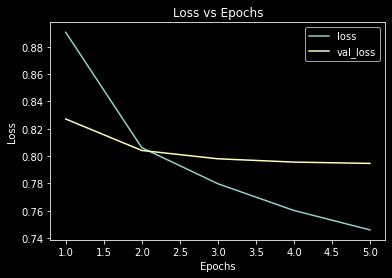

In [32]:
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model = torch.load(os.path.join(OUTPUT_FOLDER, 'cnn_big_model_500_with_padding_tanh.pth'))
cnn_model.eval()
loss_df = pd.read_csv(os.path.join(OUTPUT_FOLDER, 'plots','cnn_class_big_loss_with_padding_tanh.csv'))
print(loss_df.columns)
with torch.no_grad():
        for index, row in enumerate(test_loader):
                # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
                features, labels = row
                bow_vec = features
                probs = cnn_model(bow_vec)
                _, predicted = torch.max(probs.data, 1)
                bow_cnn_predictions.append(predicted.cpu().numpy()[0])
                original_lables_cnn_bow.append(labels.cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))

loss_file_name = os.path.join(OUTPUT_FOLDER, 'plots', 'cnn_class_big_loss_with_padding_tanh.csv')
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)

# train loss
plt_500_padding_30_epochs = loss_df.plot(x="iter", y=["loss", "val_loss"])
# val loss
plt_500_padding_30_epochs.set_xlabel("Epochs")
plt_500_padding_30_epochs.set_ylabel("Loss")
plt_500_padding_30_epochs.set_title("Loss vs Epochs")
fig = plt_500_padding_30_epochs.get_figure()

fig.savefig(os.path.join(OUTPUT_FOLDER, 'plots', "cnn_class_big_loss_with_padding_tanh.pdf"))

ReLU as Activation Function

In [14]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifierRelu(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifierRelu, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.relu(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [20]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model_relu = CnnTextClassifierRelu(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
print(cnn_model_relu)
cnn_model_relu.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_relu.parameters(), lr=0.001)
num_epochs = 5

print("Total parameters:", sum(p.numel() for p in cnn_model_relu.parameters()))
print("Trainable parameters:", sum(p.numel() for p in cnn_model_relu.parameters() if p.requires_grad))

import time

# Open the file for writing loss
loss_file_name = os.path.join(OUTPUT_FOLDER, 'plots', 'cnn_class_big_loss_with_padding_relu.csv')
f = open(loss_file_name,'w')
f.write('iter,loss,val_loss,Time')
f.write('\n')
losses = []
cnn_model_relu.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    start_time = time.time()
    train_loss = 0
    val_loss = 0
    # training
    for index, row in enumerate(train_loader):
        # Clearing the accumulated gradients
        cnn_model_relu.zero_grad()

        features, labels = row

        # Make the bag of words vector for stemmed tokens 
        # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        bow_vec = features
       
        # Forward pass to get output
        probs = cnn_model_relu(bow_vec)

        # Get the target label
        # target = make_target(Y_train['sentiment'][index])
        target = labels

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    
    # # validation
    with torch.no_grad():
        cnn_model_relu.eval()
        for index, row in enumerate(val_loader):
            # Clearing the accumulated gradients
            # cnn_model.zero_grad()

            features, labels = row

            # Make the bag of words vector for stemmed tokens 
            # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
            bow_vec = features
           
            # Forward pass to get output
            probs = cnn_model_relu(bow_vec)

            # Get the target label
            # target = make_target(Y_train['sentiment'][index])
            target = labels

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_function(probs, target)
            val_loss += loss.item()

    print("Epoch ran :"+ str(epoch+1))
    print("Time taken :"+ str(time.time() - start_time))
    print("Trains Loss :"+ str(train_loss / len(train_loader)))
    print("Val Loss :"+ str(val_loss / len(val_loader)))
    f.write(str((epoch+1)) + "," + str(train_loss / len(train_loader))+ "," + str(val_loss / len(val_loader))+ "," + str(time.time() - start_time)) 
    f.write('\n')
    train_loss = 0
    val_loss = 0

torch.save(cnn_model_relu, os.path.join(OUTPUT_FOLDER, 'cnn_big_model_500_with_padding_relu.pth'))

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

CnnTextClassifierRelu(
  (embedding): Embedding(26780, 500, padding_idx=1113)
  (convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(1, 500), stride=(1, 1))
    (1): Conv2d(1, 10, kernel_size=(2, 500), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 10, kernel_size=(3, 500), stride=(1, 1), padding=(2, 0))
    (3): Conv2d(1, 10, kernel_size=(5, 500), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Total parameters: 13445163
Trainable parameters: 55163
Epoch1
Epoch ran :1
Time taken :105.09767127037048
Trains Loss :0.8931568414370219
Val Loss :0.8282652192927421
Epoch2
Epoch ran :2
Time taken :115.73754096031189
Trains Loss :0.8119710704485575
Val Loss :0.8116720997272654
Epoch3
Epoch ran :3
Time taken :133.74834632873535
Trains Loss :0.7884475519657135
Val Loss :0.8015753024436058
Epoch4
Epoch ran :4
Time taken :139.43382239341736
Trains Loss :0.7719837708473205
Val Loss :0.7964045075660057
Epoch5
Epoch ran :5
Time taken :122.68946599

Index(['iter', 'loss', 'val_loss', 'Time'], dtype='object')
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        30
           1       0.81      0.74      0.77        34
           2       0.80      0.80      0.80        30

    accuracy                           0.78        94
   macro avg       0.78      0.78      0.78        94
weighted avg       0.78      0.78      0.78        94

Index(['iter', 'loss', 'val_loss', 'Time'], dtype='object')


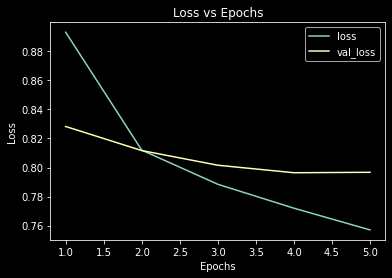

In [21]:
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model_relu = torch.load(os.path.join(OUTPUT_FOLDER, 'cnn_big_model_500_with_padding_relu.pth'))
cnn_model_relu.eval()
loss_df = pd.read_csv(os.path.join(OUTPUT_FOLDER, 'plots','cnn_class_big_loss_with_padding_relu.csv'))
print(loss_df.columns)
with torch.no_grad():
        for index, row in enumerate(test_loader):
                # bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
                features, labels = row
                bow_vec = features
                probs = cnn_model_relu(bow_vec)
                _, predicted = torch.max(probs.data, 1)
                bow_cnn_predictions.append(predicted.cpu().numpy()[0])
                original_lables_cnn_bow.append(labels.cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = os.path.join(OUTPUT_FOLDER, 'plots', 'cnn_class_big_loss_with_padding_relu.csv')
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
# train loss
plt_500_padding_30_epochs = loss_df.plot(x="iter", y=["loss", "val_loss"])
# val loss
plt_500_padding_30_epochs.set_xlabel("Epochs")
plt_500_padding_30_epochs.set_ylabel("Loss")
plt_500_padding_30_epochs.set_title("Loss vs Epochs")
fig = plt_500_padding_30_epochs.get_figure()

fig.savefig(os.path.join(OUTPUT_FOLDER, 'plots', "cnn_class_big_loss_with_padding_relu.pdf"))